# Cloud Vision API : Guide to practical use

## Why this project ?

I've always been passionated about how cutting-edge research (in particular AI) is translated into real world impact. The truth is that we live in a world where great research sometimes take several years before actually being deployed and making an impact. Conversely, promising research can sometimes end-up as a huge failure when used in the real-life. 

Therefore, I wanted to make the best AI algorithms (starting with computer vision) accessible in a line of code, so that:
* Developpers without AI expertise can use the best algorithms in their code without struggling with any integration
* AI researchers can have their code usable by the whole world without struggling with deployment and dev ops   
* More transparency is brought into the AI research world, and the strength and limitations of each algorithm becomes quickly apparent. 

Although, this project is still at its infancy, it can be compared to:
* The computer vision APIs from [Microsoft](https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision/#features), [Amazon](https://aws.amazon.com/rekognition/), and [Google](https://cloud.google.com/vision). However, these APIs do not propose most of the algorithms that are included in this API.
* What [Hugging Face](https://huggingface.co/) is doing for Natural Language Processing. HF has actually been a great source of inspiration here for me, since any developper can use state-of-the-art NLP with a few lines of code.

## API Content

The algorithms from this API are all based on great notebooks / github repositories, which I highly recommend to look at: 
* **Super-resolution**: enhances the quality of an image <br />
*Based on the [fastai notebook](https://github.com/fastai/fastai2/blob/master/nbs/course/lesson7-superres.ipynb)*
* **Style Transfer**: transform a photo into a piece of art <br />
*Based on [Zachary Mueller](https://github.com/muellerzr)'s [notebook](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/05_Style_Transfer.ipynb)*
* **Semantic Segmentation**: classifies each pixel of the picture into a class such as car, pedestrian, road, etc... <br />
*Based on [Zachary Mueller](https://github.com/muellerzr)'s [notebook](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/04_Segmentation.ipynb)*
* **Background Segmentation**: creates a mask to separate between the foreground and background in portrait pictures <br />
*Based on [Zachary Mueller](https://github.com/muellerzr)'s [notebook](https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Binary_Segmentation.ipynb)*
* **Monocular Depth Estimation**:  estimates how far each pixel is from the camera <br />
*Based on the paper ["From Big to Small: Multi-Scale Local Planar Guidance for Monocular Depth Estimation"](https://arxiv.org/pdf/1907.10326v5.pdf), currently state-of-the-art on [KITTI and MIT Datasets](https://paperswithcode.com/task/monocular-depth-estimation), and its [PyTorch implementation](https://github.com/Navhkrin/Bts-PyTorch)*. Visual results of this algorithm can be found [here](https://www.youtube.com/watch?v=ekezJiGaiQk&feature=youtu.be)

## Guidelines and limits of this API

1. The API currently officially supports **only** images < 2MB. While larger images may work, they may undergo downsizing in the process, and it might affect the quality of the results (in particular for Super-resolution where the image's details are important).
2. The *semantic segmentation and depth estimation* algorithms will work well **only on road pictures** (i.e. pictures taken from a car), because they have been trained on such datasets.
3. The *depth algorithm* has (at least) one known issue: it **always sees the sky as very close** (is that a message from above?!). An easy fix to this issue is to combine it with semantic segmentation algorithm and force "sky" pixels to get very far depth.
4. The Background segmentation algorithm will work **only on portraits/selfies**, and is currently **only giving a rough contour** (typically, it will miss the subtilities in hair)
5. In general, this is a side-project and is not considered as a finished product. Although I do my best to keep it working and resilient, the server may not be available or fail.

In general, if you have any request, feedback or question, please contact me at sebderhy@gmail.com, and I'll do my best to help.

# Let's get started !

To use this vision API, you only need the most basic python libraries, 
in particular requests to perform the HTTP requests, and PIL (Pillow) to manipulate images

In [1]:
import requests
import json
import time
from PIL import Image
import requests
from io import BytesIO

Let's choose an image URL and download it

In [2]:
URL_IMG = "https://royalbubbles.files.wordpress.com/2018/01/18157540_1722500771109745_7941673173726394531_n.jpg?w=256&h=256&crop=1"
URL_IMG = "https://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/pr/0016E5_00390.png"
URL_IMG = "https://nocamels.com/wp-content/uploads/2019/06/yandex-light.jpeg"
# URL_IMG = "https://i.pinimg.com/originals/e4/a2/d2/e4a2d21a1e545722ec3e28f85e9b1ffa.jpg"
# URL_IMG = "https://www.sparkbit.pl/wp-content/uploads/2019/07/vidar-nordli-mathisen-Kuu5mmxkwW4-unsplash.jpg"
# URL_IMG = "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQAGJWkHjFoyVewMNzdmzFIIE5bkZj3D7bBnkd4FzQoz7-WOppI&usqp=CAU"
# URL_IMG = "https://bkivey.files.wordpress.com/2018/12/OR-TV-Hwy-looking-West-181231.jpg?w=584"
URL_IMG = "https://www.go-telaviv.com/images/driving-in-israel-tel-aviv-traffic-jam1.jpg"

response = requests.get(URL_IMG)
img_pil = Image.open(BytesIO(response.content))

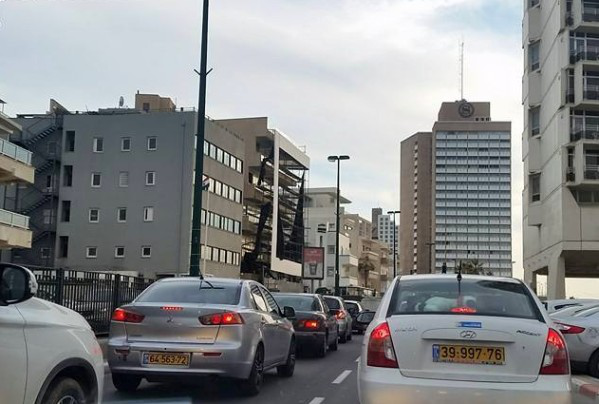

In [3]:
img_pil

In [4]:
img_pil.size

(599, 404)

In [5]:
name_img = 'test_img.png'

In [6]:
img_pil.save(name_img)

Please note that the API currently does NOT support large images, 
so we measure how big is the image and check that it does not go over ~1.5 MB. 

In [7]:
import os
os.path.getsize('test_img.png')

310388

This is the API URL that we will call

In [8]:
URL_APP = "http://visionapi.cloud/"
# URL_APP = "http://localhost/"

# Aux Functions

The functions enable you to make an API call and easily manipulate the images. Feel free to remove the decorators if you don't want it to display how long the call took. 

## Timing Decorator

In [9]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrapper(*args, **kwargs):
        start = time()
        result = f(*args, **kwargs)
        end = time()
        print('Elapsed time: {}'.format(end-start))
        return result
    return wrapper

## Image / Bytes conversion utils

In [10]:
def response2img(r):
    dataBytesIO = BytesIO(r.content)
    img =Image.open(dataBytesIO)
    return img 

In [11]:
def image_to_byte_array(image:Image):
  imgByteArr = BytesIO()
  image.save(imgByteArr, format=image.format)
  imgByteArr = imgByteArr.getvalue()
  return imgByteArr

In [12]:
import io

def to_bytes_format(im:Image.Image, format='png'):
    "Convert to bytes, default to PNG format"
    arr = io.BytesIO()
    im.save(arr, format=format)
    return arr.getvalue()

The function below is optional (it is used only to renormalize the output image). For example, it is mostly used in the depth demo 

In [13]:
import numpy as np
from PIL import Image

def do_normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

def normalize(img_pil):
#     img = Image.open(FILENAME).convert('RGBA')
    img = img_pil.convert('RGBA')
    arr = np.array(img)
    new_img = Image.fromarray(do_normalize(arr).astype('uint8'),'RGBA')
#     new_img.save('/tmp/normalized.png')
    return new_img

## API Call helpers

All the API functions can be called either from:
* Local path of an image 
* PIL image object
* URL of an image

In [14]:
@timing
def fileImgAPICall(path_img, api_path):
    # api-endpoint 
    API_ENDPOINT = f"{URL_APP}{api_path}"

    # data to be sent to api 
    files = {'file': open(path_img, 'rb')}

    # sending post request and saving response as response object 
    r = requests.post(url = API_ENDPOINT, files=files) 
    return r

In [15]:
@timing
def pilImgAPICall(img_pil, api_path):
    # api-endpoint 
    API_ENDPOINT = f"{URL_APP}{api_path}"
    
#     img_bytes = image_to_byte_array(img_pil)
    img_bytes = to_bytes_format(img_pil)
    img_bytes_io = BytesIO(img_bytes)

    # data to be sent to api 
    files = {'file':img_bytes_io}

    # sending post request and saving response as response object 
    r = requests.post(url = API_ENDPOINT, files=files) 
    return r

In [16]:
@timing
def URLImgAPICall(url, api_path):
    API_ENDPOINT = f"{URL_APP}{api_path}"

    # data to be sent to api 
    params = {'url': url}
    # sending post request and saving response as response object 
    r = requests.post(url = API_ENDPOINT, params=params)
    assert r.status_code==200
    return r

# Test Superresolution

Enhance the quality of your image!

In [17]:
name_img='test_img.png'
model_name='superres-2b'

In [18]:
r = fileImgAPICall(name_img,f'img2img/{model_name}/')
assert r.status_code==200

Elapsed time: 11.4656662940979


In [19]:
img_hr = response2img(r)

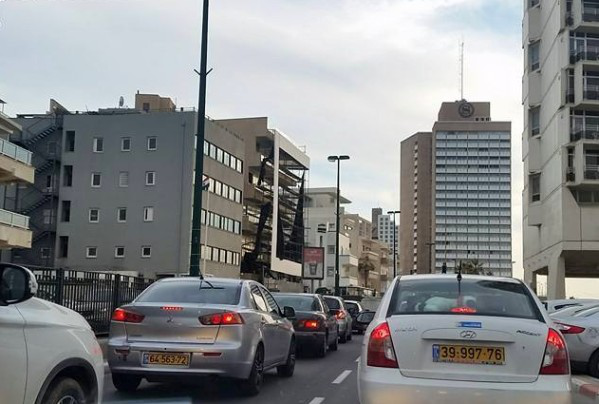

In [20]:
img_in = Image.open('test_img.png')
img_in

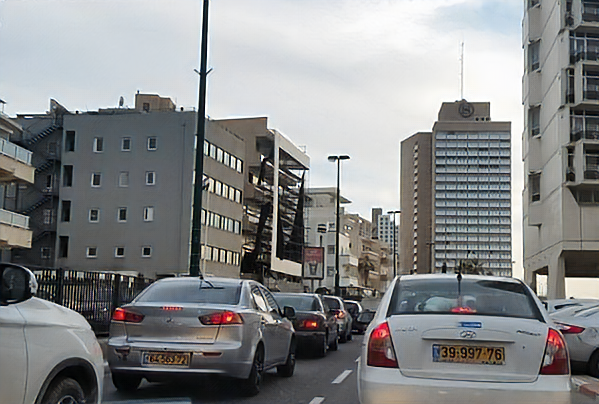

In [21]:
img_hr

In [22]:
img_hr.save(f'./img_out/{model_name}.png')

## Test Superres from URL

Reminder: all the API functions can be called either from:
* PIL image object
* Local path of an image 
* URL of an image

In [23]:
r = URLImgAPICall(URL_IMG, f'urlimg2img/{model_name}/')

Elapsed time: 7.7939863204956055


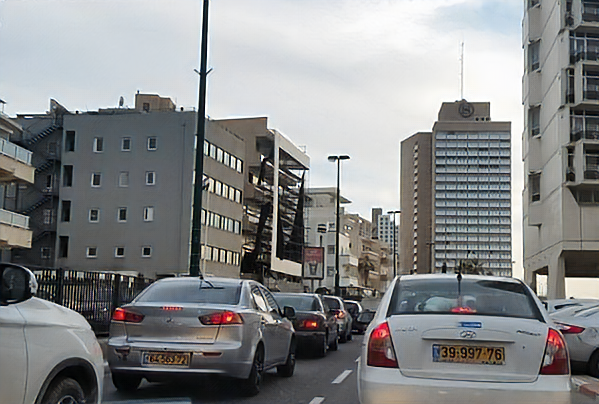

In [24]:
dataBytesIO = BytesIO(r.content)
img_hr2 = Image.open(dataBytesIO)
img_hr2

In [25]:
import numpy as np
absDiff = abs(np.array(img_hr2)-np.array(img_hr))
assert absDiff.sum()<1e-10

## Test Style Transfer

Give style to your images !

## Style 1

In [26]:
name_img='test_img.png'
model_name='styletransf-1'

In [27]:
r = fileImgAPICall(name_img,f'img2img/{model_name}/')
assert r.status_code==200

Elapsed time: 5.019355773925781


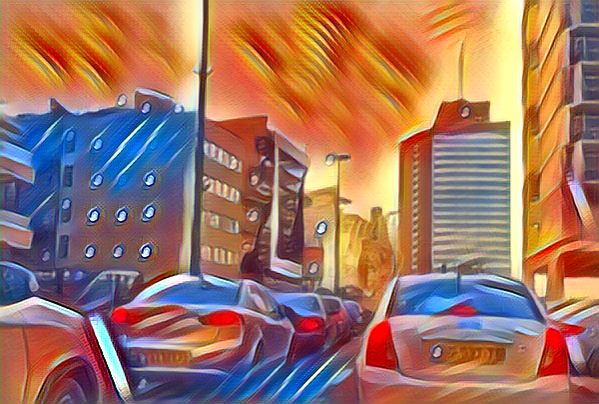

In [28]:
img_out = response2img(r)
img_out

In [29]:
img_out.save(f'./img_out/{model_name}.png')

## Style 2

In [30]:
name_img='test_img.png'
model_name='styletransf-2'

In [31]:
r = fileImgAPICall(name_img,f'img2img/{model_name}/')
assert r.status_code==200

Elapsed time: 4.998536109924316


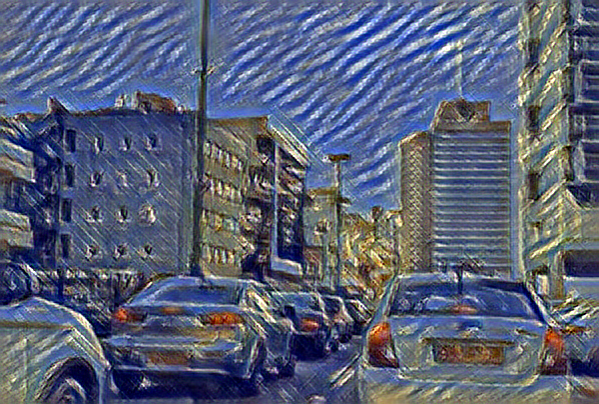

In [32]:
img_out = response2img(r)
img_out

In [33]:
img_out.save(f'./img_out/{model_name}.png')

## Style 3

In [34]:
name_img='test_img.png'
model_name='styletransf-3'

In [35]:
r = fileImgAPICall(name_img,f'img2img/{model_name}/')
assert r.status_code==200

Elapsed time: 5.267415761947632


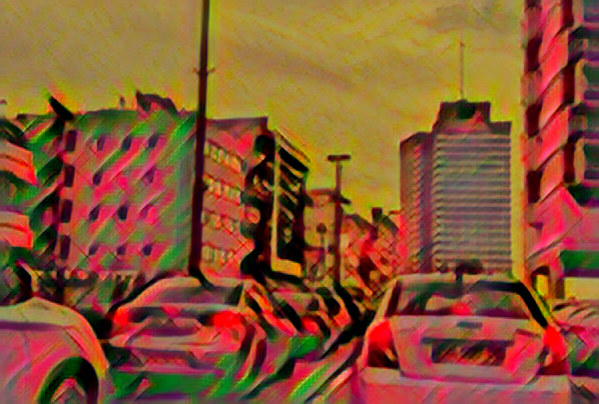

In [36]:
img_out = response2img(r)
img_out

In [37]:
img_out.save(f'./img_out/{model_name}.png')

## Test Semantic Segmentation

Semantic segmentation allows to have a per-pixel classification of the image. It is very useful in domains like Autonomous driving, where the car needs to have an accurate understanding of its surroundings

NOTE: this algorithm was trained on autonomous driving datasets, and therefore will not work well on images that are not similar to what a car sees on the road.

In [69]:
name_img='test_img.png'
model_name='semseg-3'

In [70]:
r = fileImgAPICall(name_img,f'img2img/{model_name}/')

assert r.status_code==200

Elapsed time: 7.561906099319458


In [71]:
img_out = response2img(r)
img_out.size

(599, 404)

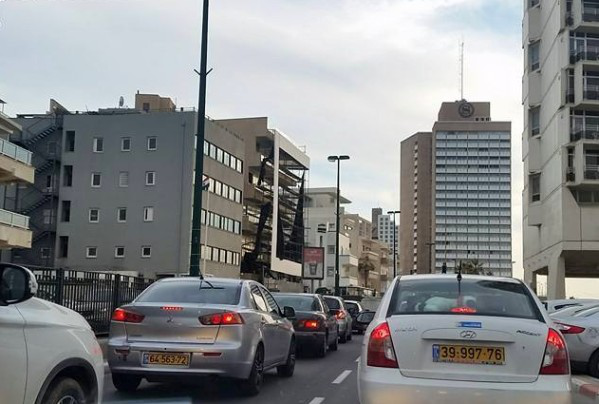

In [72]:
img_in = Image.open('test_img.png')
img_in

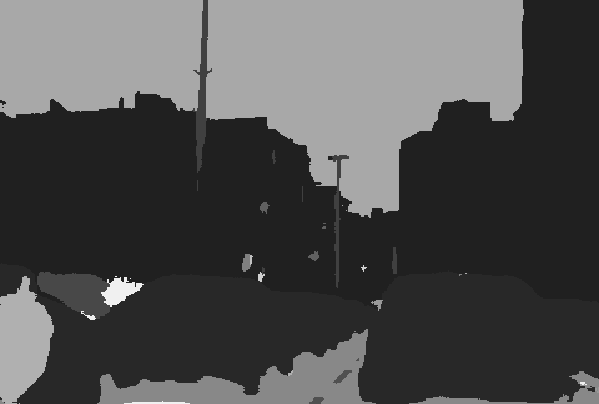

In [73]:
img_out

Below is a blended view, i.e. we overlay the semantic segmentation with the original image to see the differences

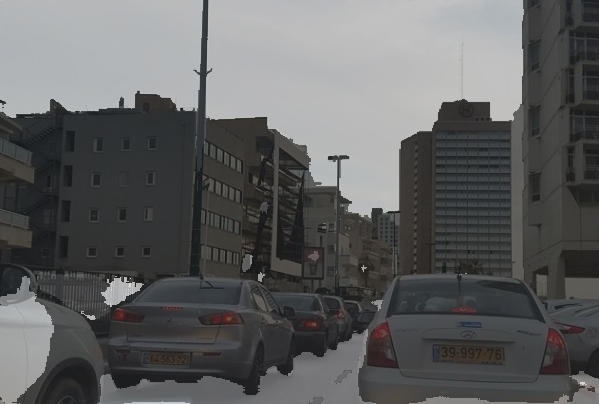

In [43]:
img_out2 = img_out.convert('RGB')
img_out3 = Image.blend(img_in, img_out2, alpha=0.7)
img_out3

In [44]:
img_out3.save(f'./img_out/{model_name}.png')

In [45]:
assert(img_in.size==img_out.size)

Below is the code that enables to get a pixel's class.

In [46]:
codes = ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall']

In [47]:
cols,rows = img_out.size
codes[img_out.getpixel((50,50))//8]

'Sky'

In [48]:
cols,rows = img_out.size
codes[img_out.getpixel((cols-100,rows-50))//8]

'Car'

# Depth for road vision

Depth estimation is the task of giving the distance of each pixel to the camera. It is key in domains like autonomous driving, where the car needs to understand how far are each components.

NOTE: this algorithm was trained on autonomous driving datasets, and therefore will not work well on images that are not similar to what a car sees on the road.

In [49]:
name_img='test_img.png'
model_name='depth-bts'

In [50]:
r = fileImgAPICall(name_img,f'img2img/{model_name}/')

assert r.status_code==200

Elapsed time: 9.878889322280884


In [51]:
img_out = response2img(r)

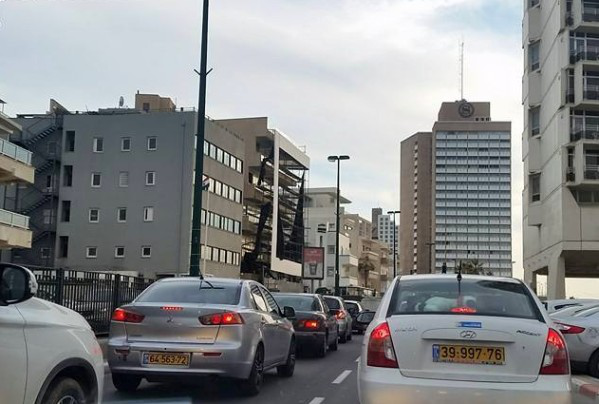

In [52]:
img_in = Image.open(name_img)
img_in

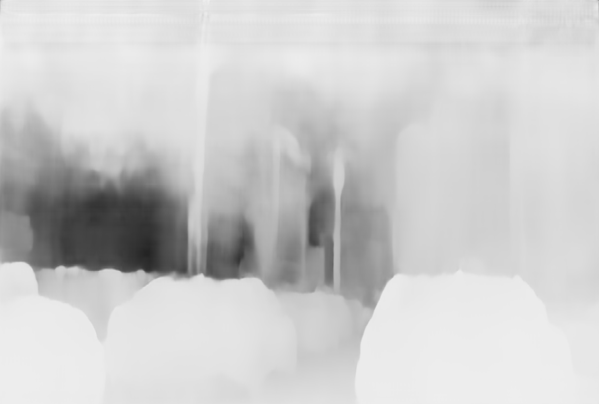

In [53]:
img_out

Below is a normalized version, mostly for "demo" purpose. It is recommended to use the real version if you are really interested by the depth.

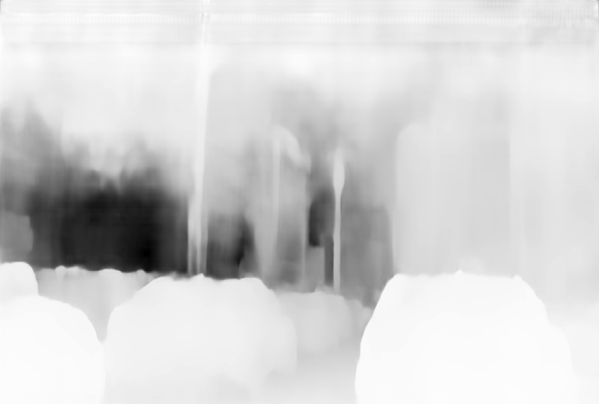

In [54]:
img_out2=normalize(img_out)
img_out2

In [55]:
img_out2.save(f'./img_out/{model_name}.png')

## Background Segmentation

The task of background is very useful for selfie enhancement. As it names says, it enables to segment the background from the actual person taken.

NOTE: this algorithm should be applied ONLY to portrait photos or selfies. 

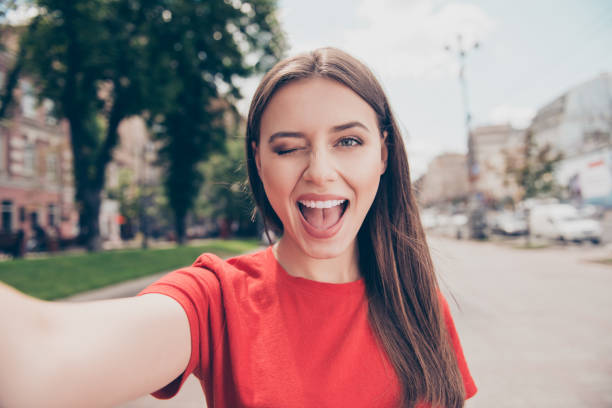

In [56]:
URL_IMG = "https://media.istockphoto.com/photos/young-woman-with-dark-hair-winks-and-wide-open-her-mouth-shooting-on-picture-id1041748522?k=6&m=1041748522&s=612x612&w=0&h=v6n59Ir1AoKWyAFXX-SOuXN_F4NLKoKbxauTLkxt2sI="

response = requests.get(URL_IMG)
img_pil = Image.open(BytesIO(response.content))
img_pil

In [57]:
model_name='binseg-3'

In [58]:
r = pilImgAPICall(img_pil,f'img2img/{model_name}/')
assert r.status_code==200

Elapsed time: 5.958941459655762


In [59]:
img_out = response2img(r)

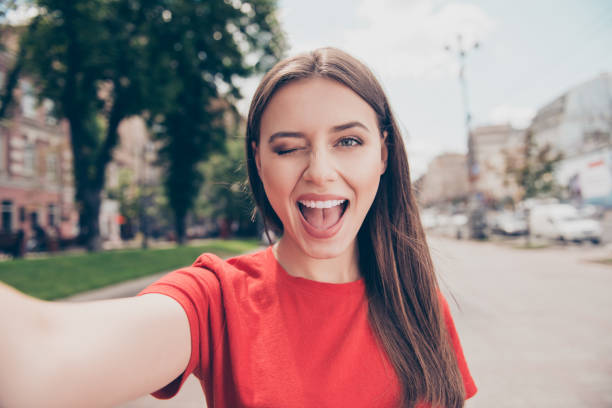

In [60]:
img_in = img_pil
img_in

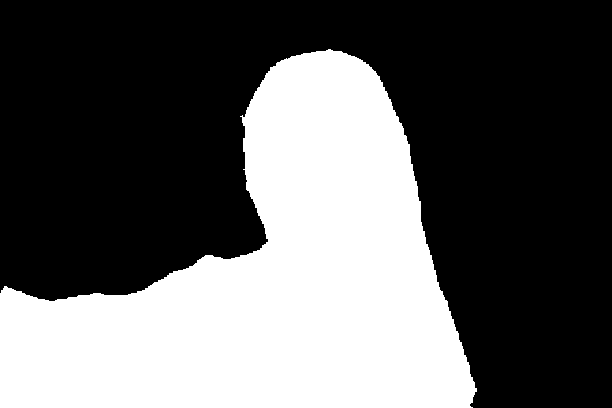

In [61]:
img_out

Here again, we use a blended view to estimate the results quality

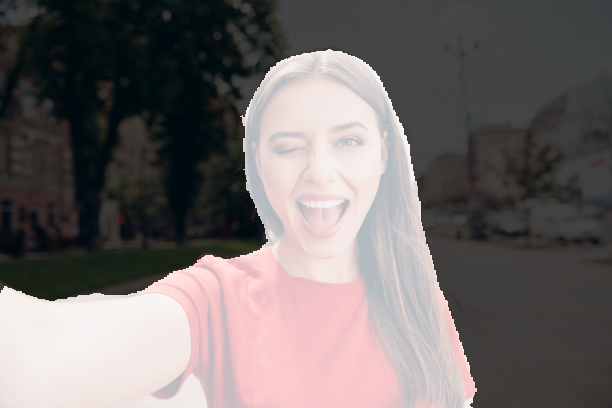

In [62]:
img_out2 = img_out.convert('RGB')
img_out3 = Image.blend(img_in, img_out2, alpha=0.7)
img_out3

In [63]:
img_out3.save(f'./img_out/{model_name}.png')

## Demo: switch the background !

In [64]:
URL_BG = 'https://img.theculturetrip.com/768x432/wp-content/uploads/2018/01/webp-net-compress-image-45.jpg'
response = requests.get(URL_BG)
bg = Image.open(BytesIO(response.content))

In [65]:
bg2 = bg.resize(img_in.size)

In [66]:
print(img_in.size)
print(img_out.size)
print(bg2.size)

(612, 408)
(612, 408)
(612, 408)


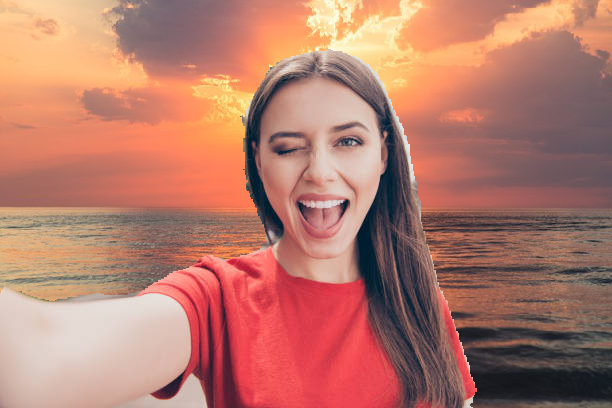

In [67]:
img_out4=Image.composite(img_in, bg2, img_out)
img_out4

In [68]:
img_out4.save(f'./img_out/{model_name}_bgswap.png')